<div align=right>
Winter 2025<br>
Nardin<br>
HW5
</div>


<font color='darkblue'> <h2 align=center> Homework 5: Record Linkage (with `recordlinkage` library) </h2> </font>

### Instructions

In class, we used `fodor.txt` and `zagat.txt` to illustrate the record linkage pipeline. **The goal of this homework is to further practice using the `recordlinkage` library with the same data we used in class. Complete all questions below with both code and written text (in Markdown).** 

Please remember: 
* Submit on Gradescope your Jupyter notebook with the homework completed and the output of your code visible. Ensure the file is not too large for Gradescope. Do not submit the data, we only need the notebook.
* HWs must be completed individually and are graded on a Pass-Fail basis. Before submitting, see the Syllabus for homework policies (what qualifies as a "Pass", deadlines, regrading, etc.)
* At the end of the notebook include the resources you consulted, and some reflections on what you learned. **Submissions without resources and reflections will automatically be graded as "Fail"**

### Questions

<b>Question 1: Load the required libraries, load both datasets in Pandas, and pre-process/clean them</b> 

* Your input should be the in-class datasets: `fodor.txt` and `zagat.txt`.
* Your output should be the two datasets cleaned and standardized, ready to be used for record linkage.
* In class, we illustrated pre-processing data using the zagat dataset. Your code should not copy/paste the code shown in class: use a different approach or improve the code illustrated in class, and apply it to both datasets. Remember the trade off between time and results.
* Add a few sentences (in Markdown) to explain your data-preprocessing strategy/choices.

**Explanation:**

For the step of pre-process, after using pd.read_csv and .isna().sum() to screen our data, I changed a regular expression from r"([^\d]*)(\d.*)(\..*)" to "(.*?)(\d+.*?)(\s*\w+\s*\w+\s*\w*$)".

After parsing the string into name, street, and city, we furthur investigate if any input that did not follow the pattern and observe. Then, I fixed those fixable and drop those ambiguous or incomplete inputs.

In [1]:
import re
import pandas as pd
import jellyfish
import recordlinkage

In [2]:
fodor = pd.read_csv("fodor.txt", header = None)
print(len(fodor.index))
fodor.head()

533


,0
0,Adriano's Ristorante 2930 Beverly Glen Circle ...
1,Arnie Morton's of Chicago 435 S. La Cienega Bl...
2,Art's Delicatessen 12224 Ventura Blvd. Studio ...
3,Barney Greengrass 9570 Wilshire Blvd. Beverly ...
4,Beaurivage 26025 Pacific Coast Hwy. Malibu


In [3]:
zagat = pd.read_csv("zagat.txt", header = None)
print(len(zagat))
zagat[:5]

331


,0
0,Apple Pan The 10801 W. Pico Blvd. West LA
1,Arnie Morton's of Chicago 435 S. La Cienega Bl...
2,Art's Deli 12224 Ventura Blvd. Studio City
3,Asahi Ramen 2027 Sawtelle Blvd. West LA
4,Baja Fresh 3345 Kimber Dr. Westlake Village


In [4]:
# my_reg = (r'([^\d]*)(\d.*)(\..*)')
my_reg = r'(.*?)(\d+.*?)(\s*\w+\s*\w+\s*\w*$)'

In [5]:
zagat_df = zagat.iloc[:, 0].str.extract(my_reg, expand=True)
zagat_df.head()

,0,1,2
0,Apple Pan The,10801 W. Pico Blvd.,West LA
1,Arnie Morton's of Chicago,435 S. La Cienega Blvd.,Los Angeles
2,Art's Deli,12224 Ventura Blvd.,Studio City
3,Asahi Ramen,2027 Sawtelle Blvd.,West LA
4,Baja Fresh,3345 Kimber Dr.,Westlake Village


In [6]:
fodor_df = fodor.iloc[:,0].str.extract(my_reg, expand=True)
fodor_df.head()

,0,1,2
0,Adriano's Ristorante,2930 Beverly Glen Circle,Los Angeles
1,Arnie Morton's of Chicago,435 S. La Cienega Blvd.,Los Angeles
2,Art's Delicatessen,12224 Ventura Blvd.,Studio City
3,Barney Greengrass,9570 Wilshire Blvd.,Beverly Hills
4,Beaurivage,26025 Pacific Coast Hwy.,Malibu


In [7]:
# count null records
print(fodor_df.isna().sum())
print(zagat_df.isna().sum())

0    9
1    9
2    9
dtype: int64
0    3
1    3
2    3
dtype: int64


**Zagat**

In [8]:
# check these problematic records
errors_za = zagat_df[zagat_df[0].isnull()].index.to_series()
print(type(errors_za))
print(errors_za)

<class 'pandas.core.series.Series'>
48      48
150    150
176    176
dtype: int64


In [9]:
# look them up in original zagat data to understand why regex did not work on them
pd.options.display.max_colwidth = 100
zagat.iloc[errors_za]

,0
48,La Serenata de Garibaldi 1842 E. First St. Boyle Hts.
150,Oyster Bar lower level New York City
176,Tavern on the Green Central Park West New York City


In [10]:
# fix it 
err_df_za = zagat.iloc[errors_za]

# with another regex
new_regex = r"([^\d]*)(\d.*)(New York City|Boyle Hts.)"
err_df_za[0].str.extract(new_regex, expand=True)

,0,1,2
48,La Serenata de Garibaldi,1842 E. First St.,Boyle Hts.
150,NaN,NaN,NaN
176,NaN,NaN,NaN


In [11]:
# apply
err_df_za = err_df_za[0].str.extract(new_regex, expand=True)
err_df_za.head()

,0,1,2
48,La Serenata de Garibaldi,1842 E. First St.,Boyle Hts.
150,NaN,NaN,NaN
176,NaN,NaN,NaN


In [12]:
# check
print(err_df_za[err_df_za[0].isna()])

       0    1    2
150  NaN  NaN  NaN
176  NaN  NaN  NaN


In [13]:
# update original data
zagat_df.update(err_df_za, join='left', overwrite=True)

In [14]:
# check
print(zagat_df.isna().sum())

0    2
1    2
2    2
dtype: int64


In [15]:
zagat_df.dropna(inplace=True)

**Fordor**

In [16]:
# check these problematic records
errors_fo = fodor_df[fodor_df[0].isnull()].index.to_series()
print(errors_fo)

356    356
371    371
372    372
378    378
396    396
461    461
462    462
464    464
491    491
dtype: int64


In [17]:
# look them up in original fodor data to understand why regex did not work on them
pd.options.display.max_colwidth = 100
fodor.iloc[errors_fo]

,0
356,Dante's Down the Hatch Underground Underground Mall Underground Atlanta Atlanta
371,La Grotta at Ravinia Dunwoody Rd. Holiday Inn/Crowne Plaza at Ravinia Dunwoody Atlanta
372,Little Szechuan C Buford Hwy. Northwoods Plaza Doraville Atlanta
378,Mi Spia Dunwoody Rd. Park Place across from Perimeter Mall Dunwoody Atlanta
396,Toulouse B Peachtree Rd. Atlanta
461,Garden Court Market and New Montgomery Sts. San Francisco
462,Gaylord's Ghirardelli Sq. San Francisco
464,Greens Bldg. A Fort Mason San Francisco
491,McCormick & Kuleto's Ghirardelli Sq. San Francisco


In [18]:
fodor_df.dropna(inplace=True)

In [19]:
print(len(fodor_df))
print(len(zagat_df))

524
329


In [20]:
from recordlinkage.standardise import clean

In [21]:
# check data
zagat_df[:5]

# apply clean() to each columns of zagat_df
zagat_df['name'] = clean(zagat_df[0])
zagat_df['address'] = clean(zagat_df[1])
zagat_df['city'] = clean(zagat_df[2])
zagat_df.head(3)

,0,1,2,name,address,city
0,Apple Pan The,10801 W. Pico Blvd.,West LA,apple pan the,10801 w pico blvd,west la
1,Arnie Morton's of Chicago,435 S. La Cienega Blvd.,Los Angeles,arnie mortons of chicago,435 s la cienega blvd,los angeles
2,Art's Deli,12224 Ventura Blvd.,Studio City,arts deli,12224 ventura blvd,studio city


In [22]:
# repeat for fodor
fodor_df[['name', 'address', 'city']] = fodor_df[[0, 1, 2]].apply(clean)
fodor_df.head()

,0,1,2,name,address,city
0,Adriano's Ristorante,2930 Beverly Glen Circle,Los Angeles,adrianos ristorante,2930 beverly glen circle,los angeles
1,Arnie Morton's of Chicago,435 S. La Cienega Blvd.,Los Angeles,arnie mortons of chicago,435 s la cienega blvd,los angeles
2,Art's Delicatessen,12224 Ventura Blvd.,Studio City,arts delicatessen,12224 ventura blvd,studio city
3,Barney Greengrass,9570 Wilshire Blvd.,Beverly Hills,barney greengrass,9570 wilshire blvd,beverly hills
4,Beaurivage,26025 Pacific Coast Hwy.,Malibu,beaurivage,26025 pacific coast hwy,malibu


In [23]:
# create two new pd with cleaned columns 

# rename data 
zagat_clean = zagat_df.drop(zagat_df.columns[[0, 1, 2]], axis=1) 
fodor_clean = fodor_df.drop(fodor_df.columns[[0, 1, 2]], axis=1) 

# reset index
zagat_clean = zagat_clean.reset_index(drop=True)
fodor_clean = fodor_clean.reset_index(drop=True)

zagat_clean.head()

,name,address,city
0,apple pan the,10801 w pico blvd,west la
1,arnie mortons of chicago,435 s la cienega blvd,los angeles
2,arts deli,12224 ventura blvd,studio city
3,asahi ramen,2027 sawtelle blvd,west la
4,baja fresh,3345 kimber dr,westlake village


<b>Question 2: Select records to compare using either blocked indexing or full indexing from the `recordlinkage` library</b> 

* Your output should be a Pandas multiIndex object that identifies candidate links by their original indices in the two datasets being linked.
* Add a few sentences (in Markdown) to explain your strategy/choices (e.g., explain why you chose one indexing method and not the other, and how the indexing operations work).

**Explaination**: 

I chose bloked indexing of restaurant name for this step as it was more efficient than full indexing. However, it may miss some not exact match. I planned to adjust the threshold in later steps. Additionally, it used "name" as the block for indexing.

In [25]:
from recordlinkage.index import Block

In [26]:
index_block = Block(left_on = "name", right_on = "name")

In [27]:
candidate_links = index_block.index(zagat_clean, fodor_clean)

In [28]:
candidate_links[:10]

MultiIndex([( 1,   1),
            ( 9, 399),
            (15,  10),
            (17,  13),
            (20,  18),
            (21,  19),
            (28,  32),
            (45,  42),
            (50,  43),
            (52,  46)],
           )

In [29]:
zagat_clean.iloc[[1,9,15]]

,name,address,city
1,arnie mortons of chicago,435 s la cienega blvd,los angeles
9,bistro,45 45 s mentor ave,pasadena
15,cafe bizou,14016 ventura blvd,sherman oaks


In [206]:
fodor_clean.iloc[[1, 399, 10]]

,name,address,city
1,arnie mortons of chicago,435 s la cienega blvd,los angeles
399,bistro,3400 las vegas blvd s,las vegas
10,cafe bizou,14016 ventura blvd,sherman oaks


<b>Question 3: Compare the records indexed in the previous step</b> 

* Rely on the library `recordlinkage` and select the distance metrics (e.g. Jaro-Winkler, etc.) that you prefer among those supported by the library. Note you could also create a custom comparison method: see [here](https://uwaterloo.ca/networks-lab/blog/post/record-comparison-recordlinkage) and slides for more.
* Your output should be a Pandas df that stores all attribute comparisons.
* Add a few sentences (in Markdown) to explain your strategy/choices (e.g., why you choose one metric vs. another, etc.)

**Explaination:**

This step involves calculating the similarity score between attributes and outputs. I selected the Jaro-Winkler method to measure the distance between linked records because it normalizes the score between 0 and 1, making it easier to compare. I also considered other methods, such as Levenshtein and Levenshtein-Damerau, but ultimately chose Jaro-Winkler for its normalization and suitability for this task.

In [31]:
# from recordlinkage.compare import Exact, String, Numeric, Date
import recordlinkage.compare

In [32]:
# create a compare object
comparer = recordlinkage.Compare()

In [33]:
# compare all our columns
comparer.string("name", "name", method = "jarowinkler", label = "jw_name")
comparer.string("address", "address", method = "jarowinkler", label = "jw_address")
comparer.string("city", "city", method = "jarowinkler", label = "jw_city")

<Compare>

In [34]:
features = comparer.compute(candidate_links, zagat_clean, fodor_clean)
features.dtypes

jw_name       float64
jw_address    float64
jw_city       float64
dtype: object

In [35]:
features.head()

,,jw_name,jw_address,jw_city
1,1,1.0,1.000000,1.000000
9,399,1.0,0.568783,0.648148
15,10,1.0,1.000000,1.000000
17,13,1.0,1.000000,1.000000
20,18,1.0,1.000000,1.000000


<b>Question 4: Classify your records as match or unmatch</b> 

* Pick and apply two classification methods. You are welcome to use the same methods we have seen in class, or explore other methods. See the `recordlinkage` library documentation [here](https://recordlinkage.readthedocs.io/en/latest/ref-classifiers.html) for all available classification methods and [here](https://uwaterloo.ca/networks-lab/blog/post/record-pair-classification-recordlinkage) for more examples. Note: if you use a supervised classification method, you must create a "gold standard" dataset by manually identify and match a number of records from the datasets.
* Add a few sentences (in Markdown) to explain your strategy/choices.

**Explaination:**

I used both threshold-based linkage and rule-based linkage. After observing the probability score of matchings, I set threshold t contains most of the linkages as it was pretty strict upfront.

**Threshold-based Linkage:**

In [36]:
# check our "features" variable
features

,,jw_name,jw_address,jw_city
1,1,1.0,1.000000,1.000000
9,399,1.0,0.568783,0.648148
15,10,1.0,1.000000,1.000000
17,13,1.0,1.000000,1.000000
20,18,1.0,1.000000,1.000000
...,...,...,...,...
301,471,1.0,1.000000,1.000000
303,475,1.0,1.000000,1.000000
309,481,1.0,1.000000,1.000000
315,495,1.0,1.000000,1.000000


In [37]:
# create a column with the sum of all similarity values rounded at the second decimal
features['total'] = features.sum(axis=1).round(2)
features

,,jw_name,jw_address,jw_city,total
1,1,1.0,1.000000,1.000000,3.00
9,399,1.0,0.568783,0.648148,2.22
15,10,1.0,1.000000,1.000000,3.00
17,13,1.0,1.000000,1.000000,3.00
20,18,1.0,1.000000,1.000000,3.00
...,...,...,...,...,...
301,471,1.0,1.000000,1.000000,3.00
303,475,1.0,1.000000,1.000000,3.00
309,481,1.0,1.000000,1.000000,3.00
315,495,1.0,1.000000,1.000000,3.00


In [38]:
# check the distribution
features['total'].describe()

count    87.000000
mean      2.429655
std       0.612111
min       0.520000
25%       2.280000
50%       2.360000
75%       3.000000
max       3.000000
Name: total, dtype: float64

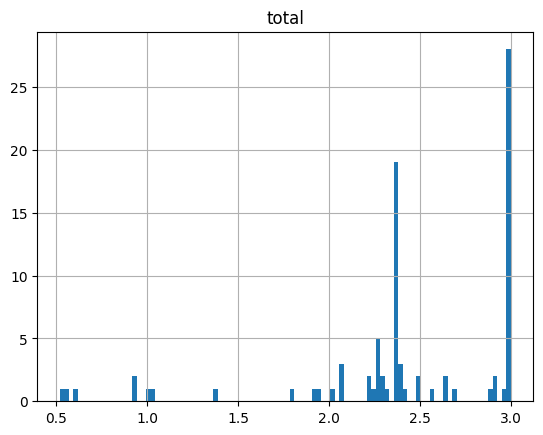

In [39]:
# plot distribution
#import matplotlib.pyplot as plt

%matplotlib inline
features.hist(column="total", bins=100);

In [40]:
# get counts
count = features["total"].value_counts()
print(count.sort_index(ascending=False))

total
3.00    28
2.96     1
2.92     1
2.91     1
2.89     1
2.68     1
2.65     1
2.63     1
2.57     1
2.50     1
2.49     1
2.42     1
2.40     1
2.38     2
2.36    19
2.31     1
2.29     2
2.28     3
2.27     1
2.26     1
2.24     1
2.22     1
2.21     1
2.08     1
2.07     1
2.06     1
2.02     1
1.95     1
1.91     1
1.79     1
1.38     1
1.04     1
1.01     1
0.93     1
0.92     1
0.60     1
0.55     1
0.52     1
Name: count, dtype: int64


In [41]:
# set a thresold to classify
thr_matches = features[(features["total"] >= 1.5)]
print("Threshold-based approach: {} matches".format(len(thr_matches)))

Threshold-based approach: 79 matches


In [42]:
thr_matches

,,jw_name,jw_address,jw_city,total
1,1,1.0,1.000000,1.000000,3.00
9,399,1.0,0.568783,0.648148,2.22
15,10,1.0,1.000000,1.000000,3.00
17,13,1.0,1.000000,1.000000,3.00
20,18,1.0,1.000000,1.000000,3.00
...,...,...,...,...,...
301,471,1.0,1.000000,1.000000,3.00
303,475,1.0,1.000000,1.000000,3.00
309,481,1.0,1.000000,1.000000,3.00
315,495,1.0,1.000000,1.000000,3.00


**Rule-based Linkage:**

In [45]:
rule_matches = features[(features["jw_name"] > 0.7) &
                        (features["jw_city"] > 0.7) &
                        (features["jw_address"] > 0.8)]

In [46]:
print(len(rule_matches))
rule_matches.head()

35


,,jw_name,jw_address,jw_city,total
1,1,1.0,1.0,1.0,3.0
15,10,1.0,1.0,1.0,3.0
17,13,1.0,1.0,1.0,3.0
20,18,1.0,1.0,1.0,3.0
21,19,1.0,1.0,1.0,3.0


In [47]:
# check pairs of candidate links that have high score
from IPython.display import display
display(zagat_clean.iloc[[1, 17, 15]])
display(fodor_clean.iloc[[1, 13, 10]])

,name,address,city
1,arnie mortons of chicago,435 s la cienega blvd,los angeles
17,campanile,624 s la brea ave,los angeles
15,cafe bizou,14016 ventura blvd,sherman oaks


,name,address,city
1,arnie mortons of chicago,435 s la cienega blvd,los angeles
13,campanile,624 s la brea ave,los angeles
10,cafe bizou,14016 ventura blvd,sherman oaks


In [48]:
# access the 3rd pair of indicees 
rule_matches.index[2]

(np.int64(17), np.int64(13))

In [49]:
# pull the 3rd index for the zagat_clean df
rule_matches.index[2][0]

np.int64(17)

In [50]:
# pull the 3rd index for the fodor_clean df
rule_matches.index[2][1]

np.int64(13)

In [51]:
# store results in a list
zagat_results = []

# for every match in rule_matches.index  
for match in rule_matches.index:   
    #print(match[0])
    
    # get the location in the original dataset, and convert to a df
    df = pd.DataFrame(zagat_clean.loc[[match[0]]])  # get zagat index
    zagat_results.append(df)

In [52]:
print(len(zagat_results))

35


In [53]:
# turn lists to df
zagat_new = pd.concat(zagat_results)
zagat_new.head()

,name,address,city
1,arnie mortons of chicago,435 s la cienega blvd,los angeles
15,cafe bizou,14016 ventura blvd,sherman oaks
17,campanile,624 s la brea ave,los angeles
20,chinois on main,2709 main st,santa monica
21,citrus,6703 melrose ave,los angeles


In [54]:
fodor_results = []

for match in rule_matches.index: 
    df = pd.DataFrame(fodor_clean.loc[[match[1]]])  # get fodor index this time
    fodor_results.append(df)
    
fodor_new = pd.concat(fodor_results)
fodor_new.head()

,name,address,city
1,arnie mortons of chicago,435 s la cienega blvd,los angeles
10,cafe bizou,14016 ventura blvd,sherman oaks
13,campanile,624 s la brea ave,los angeles
18,chinois on main,2709 main st,santa monica
19,citrus,6703 melrose ave,los angeles


In [55]:
# reset index
zagat_new = zagat_new.reset_index()
fodor_new = fodor_new.reset_index()

# combine them
matched_records = pd.concat([zagat_new, fodor_new], 
                            axis=1)  # axis=1 to concatenate horizontally

In [56]:
matched_records.head()

,index,name,address,city,index,name,address,city
0,1,arnie mortons of chicago,435 s la cienega blvd,los angeles,1,arnie mortons of chicago,435 s la cienega blvd,los angeles
1,15,cafe bizou,14016 ventura blvd,sherman oaks,10,cafe bizou,14016 ventura blvd,sherman oaks
2,17,campanile,624 s la brea ave,los angeles,13,campanile,624 s la brea ave,los angeles
3,20,chinois on main,2709 main st,santa monica,18,chinois on main,2709 main st,santa monica
4,21,citrus,6703 melrose ave,los angeles,19,citrus,6703 melrose ave,los angeles


<b>Question 5: Evaluate your classification methods</b>

* Compute and compare the performance of each of the two methods you chose in question 4.
* Add a few sentences (in Markdown) to interpret the results and explain your strategy/choices.

**Explaination:**

First, setting up true matches (n=29).


In [57]:
# set up true matches
#indexer_bl = recordlinkage.BlockIndex(on=["name", "address"])

indexer_bl = Block(on=["name", "address"])

/var/folders/7h/mx7nc7vj63551qp5lczzf1lr0000gn/T/ipykernel_5751/663953196.py:4: DeprecationWarning: The argument 'on' is deprecated. Use 'left_on=...' and 'right_on=None' to simulate the behaviour of 'on'.
  indexer_bl = Block(on=["name", "address"])


In [58]:
# create a pandas MultiIndex with candidate links (e.g. true matches)
true_matches = indexer_bl.index(zagat_clean, fodor_clean)

In [59]:
# how many true matches?
len(true_matches)

29

**threshold classifer**

In [69]:
len(thr_matches)

79

In [71]:
# confusion matrix
confusion_matrix_thr = recordlinkage.confusion_matrix(links_true = true_matches, 
                                                  links_pred = thr_matches, 
                                                  total = len(features))
confusion_matrix_thr

array([[29,  0],
       [50,  8]])

|  | <b>Predicted Positives</b> | <b>Predicted Negatives</b>  |
| :- | -: | :-: |
| <b>True Positives</b> | True Positives TP | False Negatives FN |
| <b>True Negatives</b> | False Positives FP | True Negatives TN |


This returns a numpy array with the following values: 
* 29 True Positives (TP)
* 0 False Positive (FB)
* 50 False Negative (FN)
* 8 True Negative (TN)

In [72]:
print("Precision:", recordlinkage.precision(confusion_matrix_thr))
print("Recall:", recordlinkage.recall(confusion_matrix_thr))
print("F-score", recordlinkage.fscore(confusion_matrix_thr))

Precision: 0.3670886075949367
Recall: 1.0
F-score 0.5370370370370371


**rule classifier**

In [73]:
# how many matches found by our rule classifier?
len(rule_matches)

35

In [74]:
# confusion matrix
confusion_matrix = recordlinkage.confusion_matrix(links_true = true_matches, 
                                                  links_pred = rule_matches, 
                                                  total = len(features))
confusion_matrix

array([[28,  1],
       [ 7, 51]])

|  | <b>Predicted Positives</b> | <b>Predicted Negatives</b>  |
| :- | -: | :-: |
| <b>True Positives</b> | True Positives TP | False Negatives FN |
| <b>True Negatives</b> | False Positives FP | True Negatives TN |


This returns a numpy array with the following values: 
* 28 True Positives (TP)
* 1 False Positive (FB)
* 7 False Negative (FN)
* 51 True Negative (TN)

In [75]:
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("F-score", recordlinkage.fscore(confusion_matrix))

Precision: 0.8
Recall: 0.9655172413793104
F-score 0.8750000000000001


<b>Question 6: Summarize in a few sentences what you learned from this exercise and quote the resources you used. Thanks!</b>

I got a pretty high evaluation score (precision, recall, F-score). However, I am still not sure if I over-linked or under-linked compared to the one we did in classroom. I would love to have some answers for this.